### Imports:

In [4]:
# !pip install hdbscan
# !pip install sentence-transformers
# !pip install umap-learn


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

from hdbscan import HDBSCAN
from sklearn import metrics


from sentence_transformers import SentenceTransformer
import umap

In [34]:
import warnings
warnings.filterwarnings("ignore")

import os

### Loading Data:

In [35]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# train = pd.read_csv("data/train.csv")
# test = pd.read_csv("data/test.csv")
train_test = pd.concat([train, test], ignore_index=True)

### Aggregate text data and convert it into numerical format

In [ ]:
# Aggregate text data by categories, and combining all sentences per category.
aggregated_data = test.groupby("category")["text"].apply(lambda x: " ".join(x)).reset_index()


In [54]:
# Creating word embeddings using TF-IDF:
vectorizer = TfidfVectorizer()
tfidf_embeddings = vectorizer.fit_transform(aggregated_data["text"])


In [ ]:
# # Creating embeddings using a pretrained sentence-BERT model:
# model77 = SentenceTransformer('paraphrase-mpnet-base-v2')
# mpnet_embeddings = model77.encode(aggregated_data["text"])

In [84]:
umap_embeddings = umap.UMAP(n_neighbors=10,
                            n_components=5,
                            metric='cosine',
                            random_state=None).fit_transform(tfidf_embeddings)

In [94]:
hdbscan = HDBSCAN(min_cluster_size=4, min_samples=3)
aggregated_data["topic"] = hdbscan.fit_predict(umap_embeddings)

### The Categories for Each Cluster:

In [103]:
cluster_categories = {}

for cluster in aggregated_data["topic"].unique():
    unique_categories = aggregated_data[aggregated_data["topic"] == cluster]["category"].unique().tolist()
    cluster_categories[cluster] = unique_categories

cluster_categories

{3: ['Refund_not_showing_up',
  'card_payment_not_recognised',
  'declined_card_payment',
  'direct_debit_payment_not_recognised',
  'reverted_card_payment?'],
 4: ['activate_my_card',
  'card_about_to_expire',
  'card_acceptance',
  'card_arrival',
  'card_delivery_estimate',
  'card_linking',
  'card_not_working',
  'compromised_card',
  'contactless_not_working',
  'country_support',
  'disposable_card_limits',
  'get_disposable_virtual_card',
  'getting_spare_card',
  'getting_virtual_card',
  'lost_or_stolen_card',
  'lost_or_stolen_phone',
  'order_physical_card',
  'passcode_forgotten',
  'virtual_card_not_working',
  'visa_or_mastercard'],
 -1: ['age_limit',
  'balance_not_updated_after_cheque_or_cash_deposit',
  'change_pin',
  'edit_personal_details',
  'get_physical_card',
  'pending_card_payment',
  'pin_blocked',
  'request_refund',
  'terminate_account'],
 1: ['apple_pay_or_google_pay',
  'automatic_top_up',
  'pending_top_up',
  'top_up_by_card_charge',
  'top_up_by_cash

Overall I think HDBSCAN did a good job at identifying the potential clusters. It was able to categorize them into 7 different clusters (not including the noise category). Below, I outline what I believe the clusters to mean, and their potential limitations:

**Cluster -1 (Noise):**
This cluster contains a wide range of topics that do not share one common theme, but rather could fit better in one of the other 7 clusters. Some patterns in this cluster have to do with pins and personal details.

**Cluster 0 (Exchange Rates):**
The categories in this cluster are mostly related to support regarding exchange rates and currency.

**Cluster 1 (Top-up):**
The inquiries in this cluster are mostly related to top-ups (adding funds from another source). Some examples of this are: 'automatic_top_up','pending_top_up','top_up_failed', etc..

**Cluster 2 (Identity Verification):**
This is among one of the sm aller clusters, as it only contains 4 categories, but they all have to deal with verifying identity. Some examples of this are: 'unable_to_verify_identity', 'verify_my_identity' and 'why_verify_identity'.

**Cluster 3 (Card Payment Issues):**
The cluster is also very small with only 5 categories, which all have to do with Card Payments issues such as: 'card_payment_not_recognised' or 'declined_card_payment'.

**Cluster 4 (New Card and Virtual Cards):**
This was the largest out of all of the clusters, and after looking into all of the categories in it, it seemed as if it would be better split up into two main groups: 1) Virtual Cards; 2) New Card Support. For the "New Card Support" group there are multiple subgroups within this such as old card not working (lost/stolen), ordering new card and card arrival.

**Cluster 5 (Bank Transfers/Transactions):**
The inquiries in this cluster all seem to be related to bank transfers, and transaction issues. Some of these categories include: 'cancel_transfer','pending_transfer' and'transfer_into_account'.

**Cluster 6 (ATM and Cash Withdrawal):**
The categories in this cluster are primarily related to ATM and cash withdrawals. Some of the examples in this cluster includes: 'atm_support', 'card_swallowed', 'cash_withdrawal_charge' and 'pending_cash_withdrawal'.

In [106]:
# Adding topic_names column:
topic_names = {
    -1: 'Noise',
    0: 'Exchange Rates',
    1: 'Top-Up',
    2: 'Identity Verification',
    3: 'Card Payment Issues',
    4: 'New Card and Virtual Cards',
    5: 'Bank Transfers/Transactions',
    6: 'ATM/Cash Withdrawal'
}

aggregated_data['topic_names'] = aggregated_data['topic'].map(topic_names)
aggregated_data

,category,text,topic,topic_names
0,Refund_not_showing_up,The refund isn't showing up on my account. My ...,3,Card Payment Issues
1,activate_my_card,Could you please activate my card I need to ac...,4,New Card and Virtual Cards
2,age_limit,how old do i need to be to get an account for ...,-1,Noise
3,apple_pay_or_google_pay,Is the top up feature available on the Apple W...,1,Top-Up
4,atm_support,Do all ATMs take this card? Which ATMs accept ...,6,ATM/Cash Withdrawal
...,...,...,...,...
72,virtual_card_not_working,Why is my disposable virtual card being denied...,4,New Card and Virtual Cards
73,visa_or_mastercard,I like to Mastercard rather than Visa. Do I qu...,4,New Card and Virtual Cards
74,why_verify_identity,Why do you require so many details about my id...,2,Identity Verification
75,wrong_amount_of_cash_received,I don't know if this is an issue with the ATM ...,6,ATM/Cash Withdrawal


### Plotting HDBSCAN:

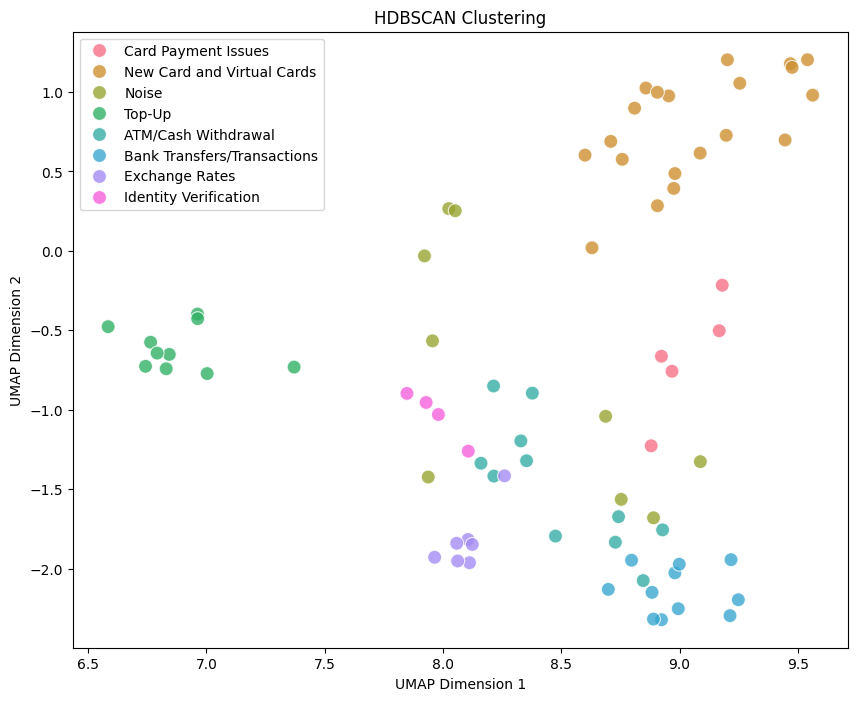

In [107]:
custom_palette = sns.color_palette("husl", len(set(hdbscan.labels_)))

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=aggregated_data["topic_names"], palette=custom_palette, legend='full', alpha=0.8, s=100)
plt.title('HDBSCAN Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

### Accuracy within each cluster (similar to Joyce's code on DBSCAN):


In [108]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [ ]:
# BERT-Banking77 model
model_id = 'philschmid/BERT-Banking77'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
classifier = pipeline('text-classification', tokenizer=tokenizer, model=model)

In [ ]:
# Inverting the dictionary
category2cluster = {}

for cluster, categories in cluster_categories.items():
  for category in categories:
    category2cluster[category] = cluster

test["topic"] = test["category"].map(category2cluster)

In [118]:
# Run the model on the entire testing set
results = []

for index, row in test.iterrows():
    text = row["text"]
    topic = row["topic"]
    prediction = classifier(text)

    # Create a result dictionary with those values below
    results.append({
        "text": text, # Storing the text for reference
        "topic": topic, # Storing the topic for future groupby
        "true_category": row["category"], # Storing the true category
        "predicted_label": prediction[0]["label"], # Storing the predicted label
        "score": prediction[0]["score"] # Storing the score of the prediction
    })

In [119]:
# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate whether the prediction was correct
results_df["is_correct"] = results_df["true_category"] == results_df["predicted_label"]

# Calculate the accuracy per topic
accuracy_per_topic = results_df.groupby("topic")["is_correct"].mean()
accuracy_per_topic

topic
-1    0.961111
 0    0.928571
 1    0.915000
 2    0.956250
 3    0.920000
 4    0.936250
 5    0.863636
 6    0.952273
Name: is_correct, dtype: float64

#### Similar to DBSCAN that Joyce showed, we can see that topic 5 or the Bank Transfer/Transactions significantly performed worst than the other categories.

In [123]:
transfer_categories = ['balance_not_updated_after_bank_transfer',
  'beneficiary_not_allowed',
  'cancel_transfer',
  'declined_transfer',
  'failed_transfer',
  'pending_transfer',
  'receiving_money',
  'top_up_by_bank_transfer_charge',
  'transfer_into_account',
  'transfer_not_received_by_recipient',
  'transfer_timing']

In [127]:
transfer_df = results_df[(results_df['predicted_label'].isin(transfer_categories)) | (results_df['true_category'].isin(transfer_categories))]
transfer_df['pred_and_true_in_transfer_topic'] = (transfer_df['predicted_label'].isin(transfer_categories)) & (transfer_df['true_category'].isin(transfer_categories))

In [128]:
false_count = transfer_df['pred_and_true_in_transfer_topic'].value_counts()[False]
true_count = transfer_df['pred_and_true_in_transfer_topic'].value_counts()[True]

percent_true = true_count/ (true_count+false_count)
percent_true

0.9330357142857143